### Решить задачу:
$ \left\{\begin{matrix}
u_{t}+u_{x}=0  \\ 
u(0,x) = sin(\frac{4 \pi x}{L}), 0 \leq x \leq L 
\end{matrix}\right. $

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import animatplot as amp


class Parameters(object):   # параметры задачи
    pass
param = Parameters() 
param.L = 20          # граница по х
param.T = 18          # граница по t
param.h = 0.5         # шаг по x
param.N = param.L/param.h + 1
t_output = [0, 3, 9, 15, 18]

def u0(x, L):   # начальное условие
    return np.sin(4 * np.pi * x / L)


def emp_output(t, x, U, output, t_output, tau):            # функция для вывода ответа
    array = np.zeros((len(t_output), len(x)))              # 4 вида вывода (output):
    for i in range(0, len(t_output)):                      # table, plotapart, plottogether, animation
        array[i][:] = U[int(t_output[i]/tau)][:]
        
    if output == 'table':
        return pd.DataFrame(array, t_output, x)
    
    if output == 'plottogether':
        plt.figure(figsize=(10, 5))
        for i in range(len(t_output)):
            plt.plot(x, array[i][:], color = (1 - 0.2 * i, 0.2 * i,  0.2 * i,), label=t_output[i], linewidth=2)
        plt.grid()
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('U')
        plt.show()
        
    if output == 'plotapart':
        for i in range(len(t_output)):
            plt.figure(figsize=(5, 2))
            plt.plot(x, array[i][:], label=t_output[i], linewidth=2)
            plt.axis([-0,20,-1,1])
            plt.grid()
            plt.xlabel('x')
            plt.ylabel('U')
            plt.show()
            
    if output == 'animation': 
        %matplotlib notebook
        X, T = np.meshgrid(x, t)
        timeline = amp.Timeline(t, units='s', fps=20)
        block = amp.blocks.Line(X, U)
        anim = amp.Animation([block], timeline)        
        plt.grid()
        plt.xlabel('x')
        plt.ylabel('U')
        anim.controls()
        plt.show()


plotapart = 'plotapart'
plottogether = 'plottogether'
table = 'table'
animation = 'animation'  

### Схема уголок: 
### $\frac{u_{m}^{n+1}-u_{m}^{n}}{\tau }+\frac{u_{m}^{n}-u_{m-1}^{n}}{h } = 0$

In [45]:
def emp_corner(p, CFL, output, t_output):      # функция для вычисления U по схеме уголок
    tau = CFL * p.h                            # построение сетки                             
    x = np.linspace(0, p.L, int(p.N))
    t = np.linspace(0, p.T, int(param.T/tau + 1)) 
    U = np.zeros([len(t),len(x)])
    
    U[:][0] = u0(x, p.L)                       # начальное условие

    for n in range(0, len(t) - 1):             # заполнение сетки
        for m in range(1, len(x)):
            U[n+1][m] = U[n][m-1] * tau / p.h + (1 - tau / p.h) * U[n][m] 
            
        U[n+1][0] = U[n+1][len(x) - 1]         # граничное условие
    return emp_output(t, x, U, output, t_output, tau)    

## CFL = 0.6

<IPython.core.display.Javascript object>


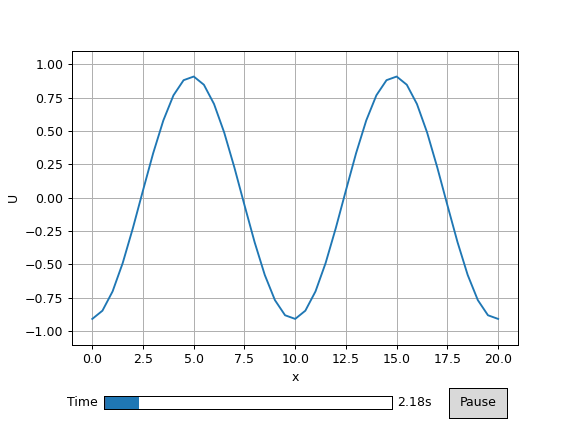

In [39]:
emp_corner(param, 0.6, animation, t_output)

## CFL = 1

<IPython.core.display.Javascript object>


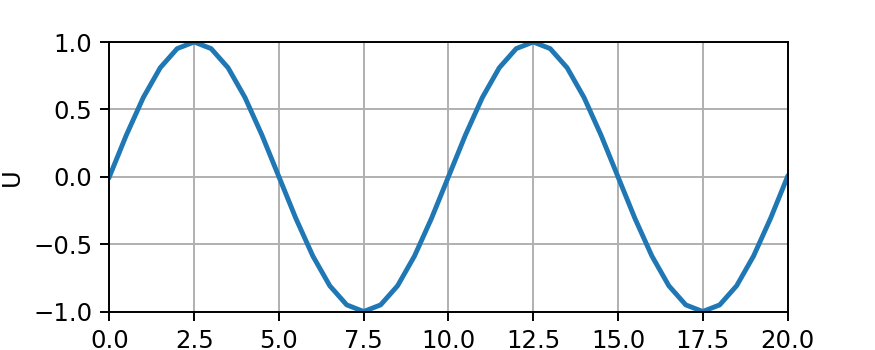

<IPython.core.display.Javascript object>


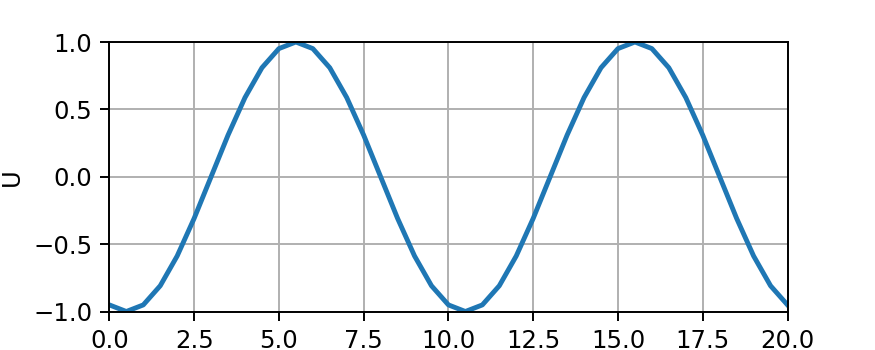

<IPython.core.display.Javascript object>


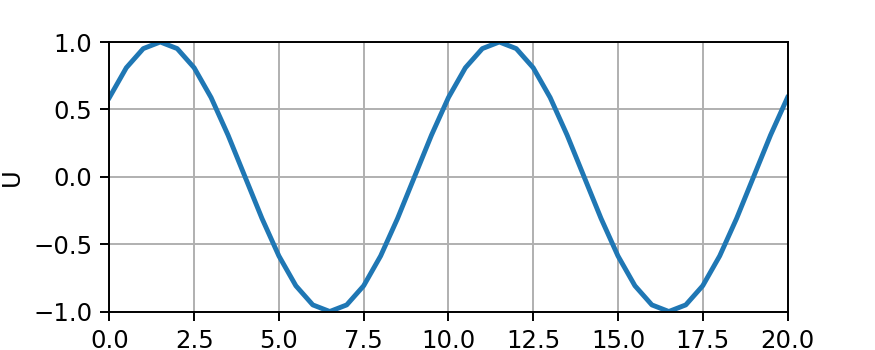

<IPython.core.display.Javascript object>


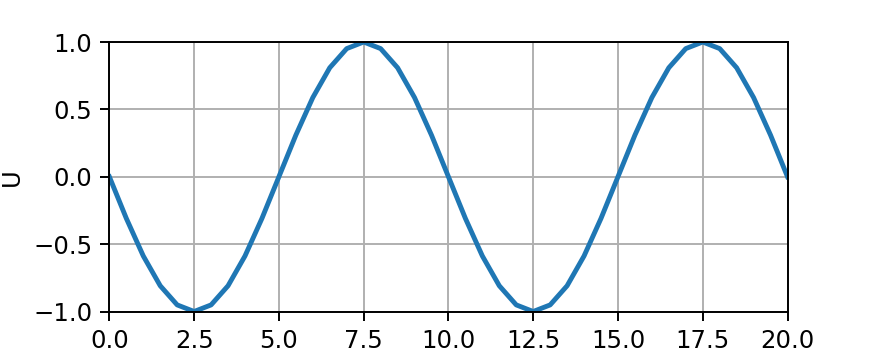

<IPython.core.display.Javascript object>


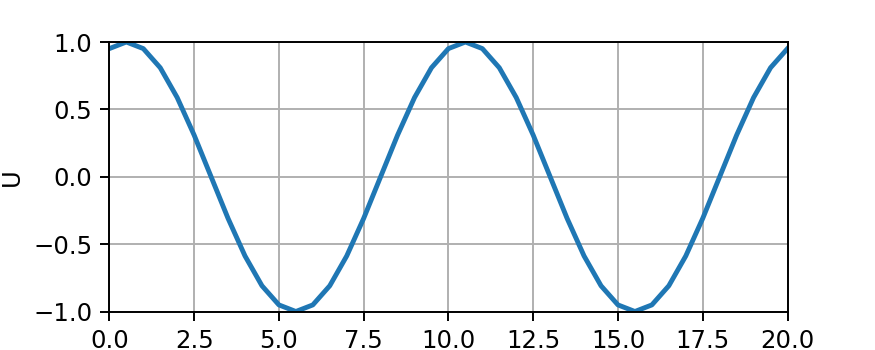

In [23]:
emp_corner(param, 1, plotapart, t_output)

## CFL = 1.01

<IPython.core.display.Javascript object>


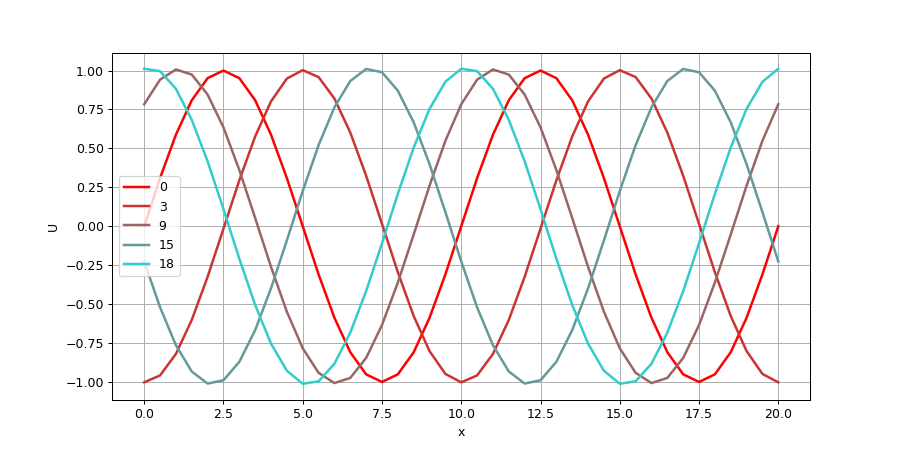

In [31]:
emp_corner(param, 1.01, plottogether, t_output)

### Схема Лакса-Вендрофа:
### $ \frac{u_{m}^{n+1} - u_{m}^{n}}{\tau} + a\frac{u_{m+1}^{n} - u_{m-1}^{n}}{2h} - \frac{a^{2}\tau }{2}\frac{u_{m+1}^{n} -2u_{m}^{n} + u_{m-1}^{n}}{h^{2}} = 0 $

In [43]:
def emp_LV(p, CFL, output, t_output):          # функция для вычисления U по схеме Лакса-Вендрофа
    tau = CFL * p.h                            # построение сетки                             
    x = np.linspace(0, p.L, int(p.N))
    NX = len(x) - 1
    t = np.linspace(0, p.T, int(param.T/tau + 1)) 
    NT = len(t) - 1
    U = np.zeros([len(t),len(x)])
    
    U[:][0] = u0(x, p.L)                       # начальное условие

    for n in range(0, NT):                     # заполнение сетки
        for m in range(1, NX):
            U[n+1][m] = U[n][m] - (tau/(2*p.h))*(U[n][m+1] - U[n][m-1]) + ((tau**2)/(2*p.h**2))*(U[n][m+1] - 2*U[n][m] + U[n][m-1])
            #U[n+1][m] = (tau**2 / (2*p.h**2) + tau / (2*p.h)) * U[n][m-1] + (1 - tau**2 / p.h**2) * U[n][m] + (tau**2 / (2*p.h**2) - tau / (2*p.h)) * U[n][m+1]
        # граничное условие
        U[n+1][NX] = U[n][NX] - (tau/(2*p.h))*(U[n][0] - U[n][NX-1]) + ((tau**2)/(2*p.h**2))*(U[n][0] - 2*U[n][NX] + U[n][NX-1])
        #U[n+1][NX] = (tau**2 / (2*p.h**2) + tau / (2*p.h)) * U[n][NX-1] + (1 - tau**2 / p.h**2) * U[n][NX] + (tau**2 / (2*p.h**2) - tau / (2*p.h)) * U[n][0]
        U[n+1][0] = U[n+1][NX]
        #U[n+1][0] = U[n][0] - (tau/(2*p.h)*(U[n][1] - U[n][NX]) + (tau**2)/(2*p.h**2)*(U[n][1] - 2*U[n][0] + U[n][NX])
        #U[n+1][0] = (tau**2 / (2*p.h**2) + tau / (2*p.h)) * U[n][NX] + (1 - tau**2 / p.h**2) * U[n][0] + (tau**2 / (2*p.h**2) - tau / (2*p.h)) * U[n][1]
    return emp_output(t, x, U, output, t_output, tau)    

## CFL = 0.6

<IPython.core.display.Javascript object>


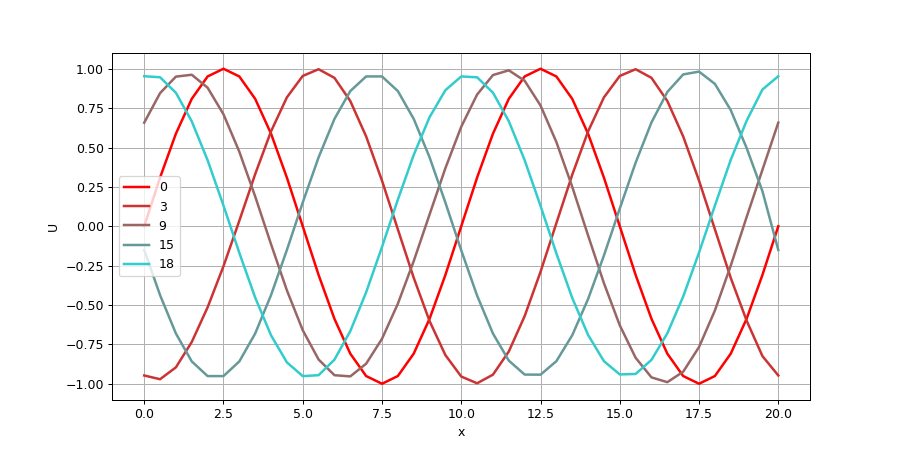

In [44]:
emp_LV(param, 0.6, plottogether, t_output)

## CFL = 1

<IPython.core.display.Javascript object>


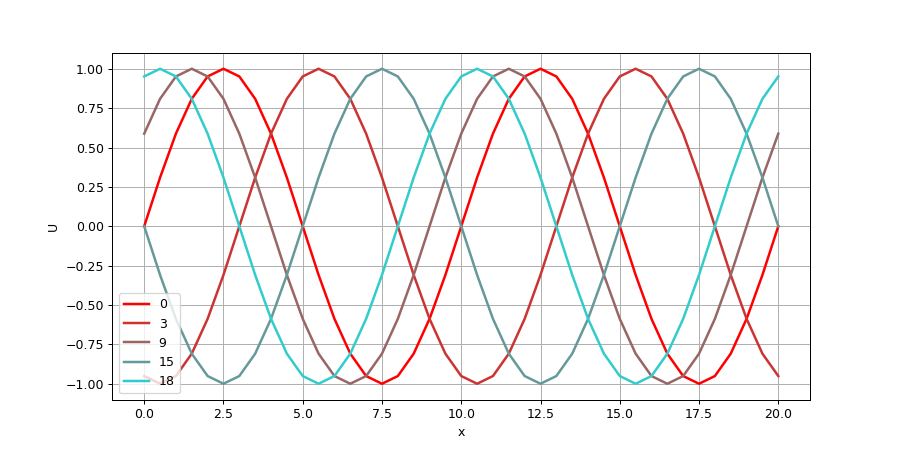

In [11]:
emp_LV(param, 1, plottogether, t_output)

## CFL = 1.01

<IPython.core.display.Javascript object>


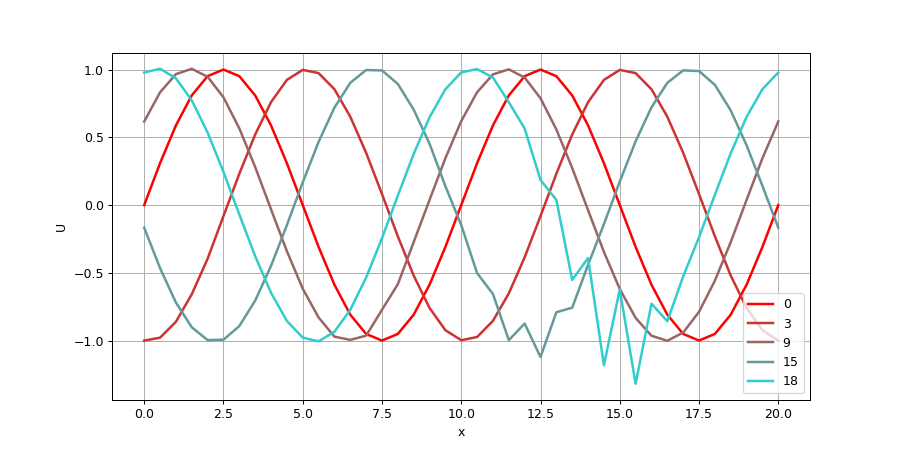

In [42]:
emp_LV(param, 1.05, plottogether, t_output)